# Investigating Ground Subsidence Across Surface Features in the Yukon River Delta, Alaska
## Nunapitchuk, AK
## Charles McGrath

## Reading and Reprojecting Data

In [1]:
from osgeo import gdal
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
from pyproj import Transformer

In [2]:
# Import data

file_paths = glob.glob("data/subsidence_data/*")

data_files = []  # List to store data files
data_bands = []  # Stores data bands
data_arrs = []   # Stores data arrays
crs = []  # Stores coordinate systems

for file in file_paths:
    file_open = gdal.Open(file)
    crs.append(file_open.GetProjection())
    data_files.append(file_open)
    data_band = file_open.GetRasterBand(1)
    data_bands.append(data_band)
    data_arr = data_band.ReadAsArray()
    data_arr = np.nan_to_num(data_arr,nan=0)
    data_arrs.append(data_arr)
    
land_cover= gdal.Open('data/land_cover.tif')
dtm = gdal.Open('data/DTM_5m_wgs84.tif')

In [3]:
# Crop each layer to specified extent


reproj_files = ['reproj_thaw_subsidence.tif','reproj_cumulative_sub.tif',  # Input raster files
                'reproj_thaw_rate.tif','reproj_alt.tif','reproj_deformation.tif']
output_files = ['thaw_subsidence_output.tif','cumulative_sub_output.tif',  # Output raster files
                'thaw_rate_output.tif','alt_output.tif','deformation_output.tif']
cropped_files = []
cropped_bands = []
cropped_arrays = []
crop_extent = [-162.6,60.927,-162.329,60.845]

for index,value in enumerate(reproj_files):  # Loop through each input raster file
    gdal.Translate(output_files[index],data_files[index],projWin=crop_extent)  # Crop files
    cropped_file = gdal.Open(output_files[index])
    cropped_files.append(cropped_file)
    cropped_band = cropped_file.GetRasterBand(1)
    cropped_bands.append(cropped_band)
    cropped_arr = cropped_band.ReadAsArray()
    cropped_arrays.append(cropped_arr)

In [10]:
# Crop elevation dataset separately

reprojected_dtm = 'dtm_reproj.tif'
translated_dtm = 'translated_dtm.tif'
gdal.Translate(translated_dtm, dtm,projWin=crop_extent)

gdal.Warp(reprojected_dtm,translated_dtm, dstSRS='EPSG:32604',resampleAlg='bilinear')
dtm_dataset = gdal.Open(reprojected_dtm)

In [11]:
# Convert coordinates of extent to easting and northing to match land cover coordinate projection

source_crs = "EPSG:4326"  # Define the source CRS (WGS84 Latitude/Longitude)
target_crs = land_cover.GetProjection() # Define the target CRS (WGS 1984 Albers)
transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True) # Create a transformer
easting, northing = transformer.transform(crop_extent[0],crop_extent[1]) # Convert to WGS 1984 Albers (easting, northing)
easting1, northing1 = transformer.transform(crop_extent[2],crop_extent[3])
lc_extent=[easting,northing,easting1,northing1] # Create list of coordinates

In [12]:
# Crop land cover data to desired extent

land_cover_file = 'land_cover.tif' 
gdal.Translate(land_cover_file, land_cover,projWin=lc_extent) 
lc_cropped = gdal.Open(land_cover_file)
lc_band1 = lc_cropped.GetRasterBand(1)
lc_arr = lc_band1.ReadAsArray()

In [13]:
# Create dictionary with land cover id as key and types as value

numbers = [11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95]
labels = ['Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, Low Intensity','Developed, Medium Intensity',
          'Developed, High Intensity','Barren Land','Deciduous Forest','Evergreen Forest','Mixed Forest','Dwarf Scrub','Shrub/Scrub',
          'Grassland/Herbaceous','Sedge/Herbaceous','Lichens','Moss','Pasture/Hay','Cultivated Crops','Woody Wetlands',
          'Emergent Herbaceous Wetlands']
land_cover_labels = dict(zip(numbers,labels))

lc_df = pd.DataFrame({'Land Cover id':numbers,'Land Cover Type':labels})

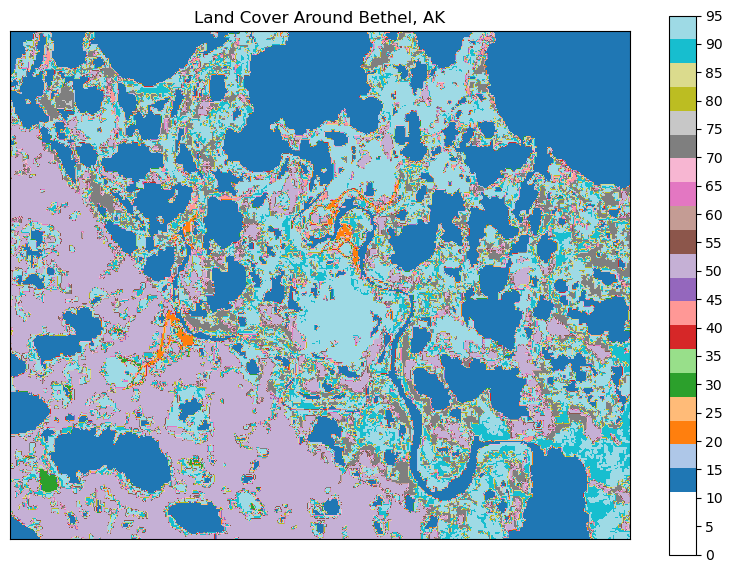

,Land Cover id,Land Cover Type
0,11,Open Water
1,12,Perennial Ice/Snow
2,21,"Developed, Open Space"
3,22,"Developed, Low Intensity"
4,23,"Developed, Medium Intensity"
5,24,"Developed, High Intensity"
6,31,Barren Land
7,41,Deciduous Forest
8,42,Evergreen Forest
9,43,Mixed Forest


In [14]:
# Plot land cover types

plt.subplots(figsize = (10,7))
plt.imshow(lc_arr,cmap='tab20')
plt.title('Land Cover Around Nunapitchuk, AK')
ticks = np.arange(0,100,5)
cbar = plt.colorbar()
cbar.set_ticks(ticks)
plt.xticks([])
plt.yticks([])
plt.show()

lc_df # Show keys for each land cover type

## Resampling the Data

In [15]:
# Resample each data source to match land cover types

output_raster = ['thaw_sub_resampled.tif','cumulative_sub_resampled.tif',  # Define output raster files
                 'thaw_rate_resampled.tif','alt_resampled.tif',
                 'deformation_resampled.tif','dtm_resampled.tif'
                 ]
read_files = {}  # Create empty dictionaries that will store raster datasets, bands, and image arrays
bands = {}
arrays = {}
reference_raster = lc_cropped  # Assign reference raster as land cover dataset
ref_cols = reference_raster.RasterXSize  # Define reference columns and rows
ref_rows = reference_raster.RasterYSize
cropped_files.append(reprojected_dtm)
input_raster = cropped_files  # Set input raster as each cropped raster dataset
for x,y in zip(output_raster,input_raster):  # Loop through each input and output raster 
    gdal.Warp(x, y,  # Reproject input raster using bilinear interpolation to match shape of land cover dataset
        width=ref_cols, 
        height=ref_rows, 
        resampleAlg=gdal.GRA_Bilinear)  
    read_file = gdal.Open(x)  # Open dataset and add to files list
    read_files[x]=read_file
    band1 = read_file.GetRasterBand(1)  # Get the raster band and add to bands list
    bands[x]=band1
    read_arr = band1.ReadAsArray()  # Read as array and add to arrays list
    arrays[x]=read_arr

In [16]:
# Resample dtm image separately to avoid errors 

reference_raster = lc_cropped
ref_cols = reference_raster.RasterXSize
ref_rows = reference_raster.RasterYSize
input_raster = reprojected_dtm
output_raster = 'dtm_resampled.tif'
gdal.Warp(output_raster, input_raster, 
          width=ref_cols, 
          height=ref_rows, 
          resampleAlg=gdal.GRA_Bilinear)  # Bilinear resampling
dtm_re = gdal.Open(output_raster)
dtm_resampled_band = dtm_re.GetRasterBand(1)
dtm_arr = dtm_resampled_band.ReadAsArray()

In [17]:
# Create new dictionary with zeros as nan values 

clean_data = {
    key: np.where(value < -100, np.nan, value)  
    for key, value in arrays.items()
}

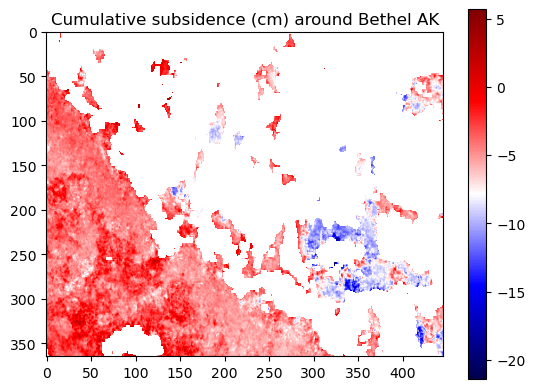

In [18]:
plt.imshow(arrays['cumulative_sub_resampled.tif'],cmap='seismic')
plt.colorbar()
plt.title('Cumulative subsidence (cm) around Nunapitchuk AK')
plt.show()

## Calculating Hillshade, Slope, and Aspect

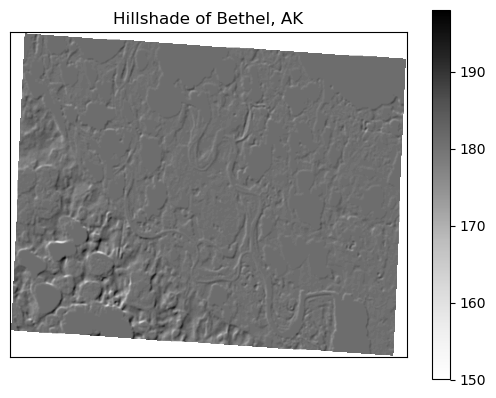

In [19]:
# Calculate and plot hillshade using resampled dtm

hillshade = gdal.DEMProcessing('hillshade.tif',dtm_re,'hillshade')
hillshade_band1 = hillshade.GetRasterBand(1)
hillshade_arr = hillshade_band1.ReadAsArray()
plt.imshow(hillshade_arr,cmap='Greys',vmin=150)
plt.title('Hillshade of Nunapitchuk, AK')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

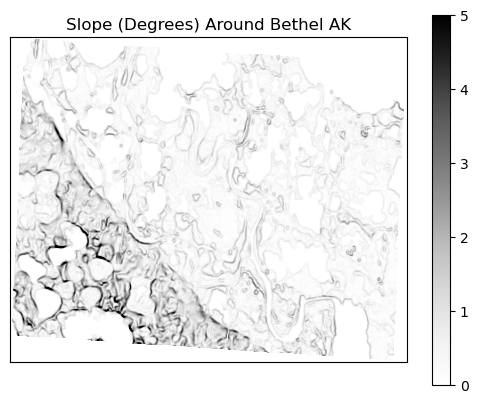

In [20]:
# Calculate and plot slope

slope = gdal.DEMProcessing('slope.tif',dtm_re,'slope',slopeFormat='degree')
slope_band1 = slope.GetRasterBand(1)
slope_arr = slope_band1.ReadAsArray()
slope_arr[np.where(slope_arr==-9999)]=np.nan
plt.imshow(slope_arr,cmap='Greys',vmin=0,vmax=5)
plt.title('Slope (Degrees) Around Nunapitchuk AK')
plt.xticks([])
plt.yticks([])
plt.colorbar()

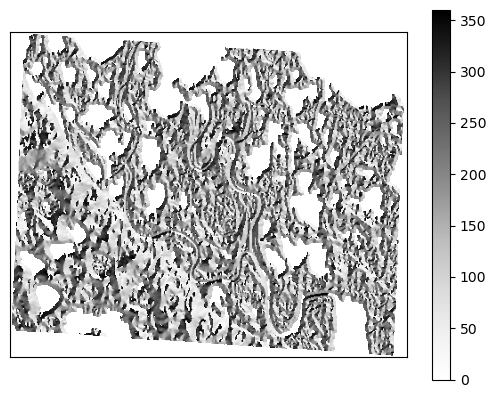

In [21]:
# Calculate and plot aspect

aspect = gdal.DEMProcessing('aspect.tif',dtm_re,'aspect')
aspect_band1 = aspect.GetRasterBand(1)
aspect_arr = aspect_band1.ReadAsArray()
plt.imshow(aspect_arr,cmap='Greys',vmin=0, vmax=360)
plt.xticks([])
plt.yticks([])
plt.colorbar()

## Mapping Subsidence Over Surface Features

In [22]:
# Create copies of each resampled raster layer

alt_copy = np.copy(clean_data['alt_resampled.tif'])
thaw_copy = np.copy(clean_data['thaw_sub_resampled.tif'])
thaw_rate_copy = np.copy(clean_data['thaw_rate_resampled.tif'])
cumulative_sub_copy = np.copy(clean_data['cumulative_sub_resampled.tif'])
def_copy = np.copy(clean_data['deformation_resampled.tif'])
slope_copy = np.copy(dtm_arr)

In [23]:
# Create copies of each layer and select pixels within urban areas

alt_urban = np.copy(alt_copy)
thaw_urban = np.copy(thaw_copy)
cumulative_urban = np.copy(cumulative_sub_copy)

for index,value in enumerate(lc_arr):  # Loop through land cover raster
    for i,v in enumerate(lc_arr[index]):
        if v<21 or v>24:  # Select pixels from raster layers that are not within urban areas in land cover layer
            alt_urban[index][i]=np.nan
            thaw_urban[index][i]=np.nan
            cumulative_urban[index][i]=np.nan

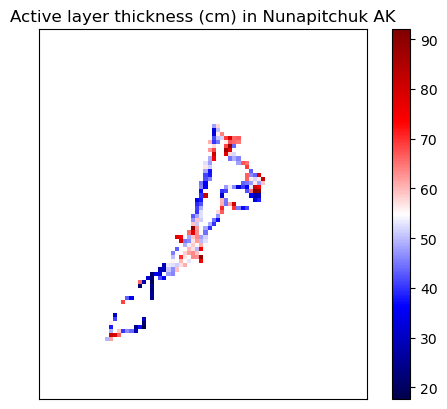

In [30]:
# Plot active layer thickness in Nunapitchuk AK

plt.imshow(alt_urban[180:270,70:150],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Active layer thickness (cm) in Nunapitchuk AK')
plt.show()

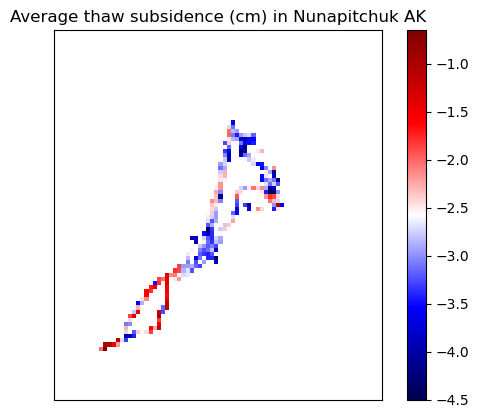

In [31]:
# Plot average thaw subsidence in Nunapitchuk AK

plt.imshow(thaw_urban[180:270,70:150],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Average thaw subsidence (cm) in Nunapitchuk AK')
plt.show()

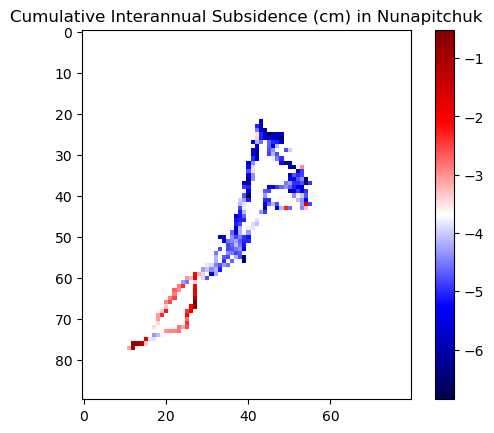

In [52]:
# Plot cumulative thaw subsidence in Nunapitchuk AK

plt.imshow(cumulative_urban[180:270,70:150],cmap='seismic')
plt.colorbar()

plt.title('Cumulative Interannual Subsidence (cm) in Nunapitchuk')
plt.show()

In [42]:
# Create copies of each layer and select pixels within areas marked by scrubland

cumulative_scrub = np.copy(cumulative_sub_copy)
alt_scrub = np.copy(alt_copy)
for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v<51 or v>52:
            cumulative_scrub[index][i]=np.nan
            alt_scrub[index][i]=np.nan

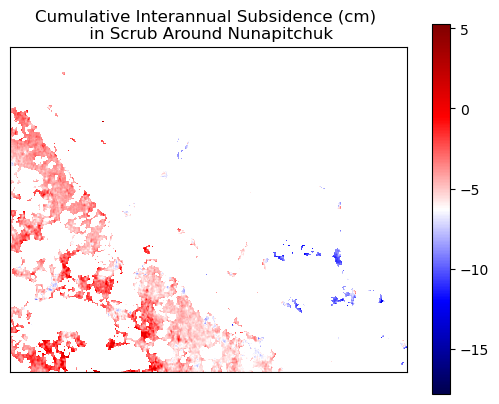

In [53]:
# Plot ground deformation within scrubland around Nunapitchuk

plt.imshow(cumulative_scrub,cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Cumulative Interannual Subsidence (cm) \n in Scrub Around Nunapitchuk' )
plt.show()

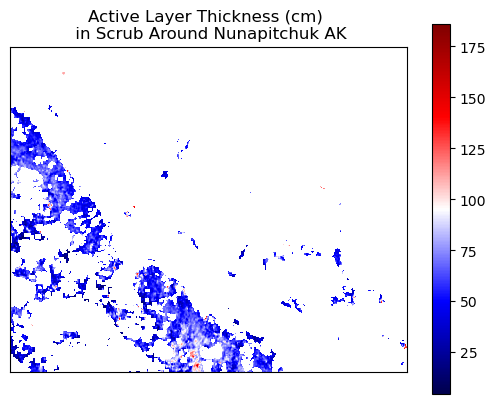

In [57]:
# Plot active layer thickness within scrubland around Nunapitchuk

plt.imshow(alt_scrub,cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Active Layer Thickness (cm) \n in Scrub Around Nunapitchuk AK')
plt.show()

In [58]:
# Create copies of each layer and select pixels within areas marked by scrubland

def_wetlands = np.copy(def_copy)
alt_wetlands = np.copy(alt_copy)
cumulative_sub_wetlands = np.copy(cumulative_sub_copy)

for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v!=90 and v!=95:
            def_wetlands[index][i]=np.nan
            alt_wetlands[index][i]=np.nan
            cumulative_sub_wetlands[index][i]=np.nan

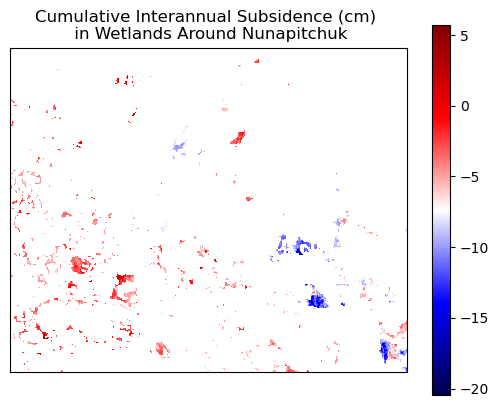

In [59]:
# Plot cumulative subsidence in wetlands around Nunapitchuk

plt.imshow(cumulative_sub_wetlands,cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Cumulative Interannual Subsidence (cm) \n in Wetlands Around Nunapitchuk' )
plt.show()

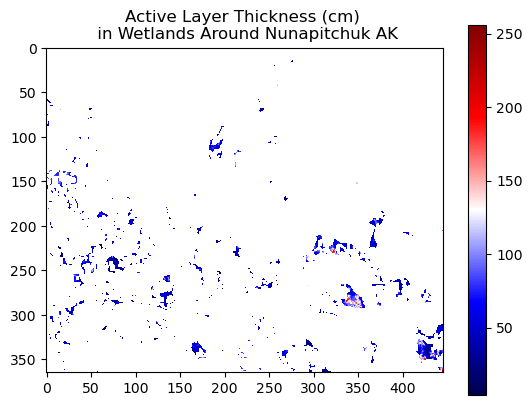

In [60]:
# Plot active layer thickness in wetlands around Nunapitchuk

plt.imshow(alt_wetlands,cmap='seismic')
plt.title('Active Layer Thickness (cm) \n in Wetlands Around Nunapitchuk AK')
plt.colorbar()
plt.show()

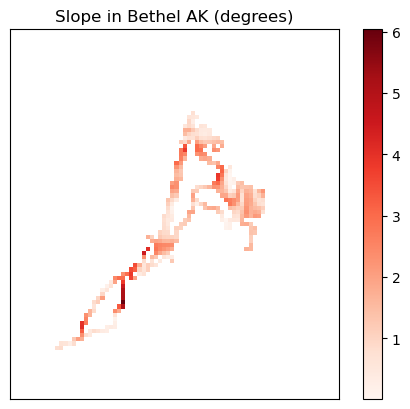

In [62]:
# Extract slope pixels within Nunapitchuk urban areas

slope_urban = np.copy(slope_arr)
for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v<21 or v>24:
            slope_urban[index][i]=np.nan     
            
# Plot slope within Nunapitchuk urban areas 

plt.imshow(slope_urban[180:270,70:150],cmap='Reds')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Slope in Nunapitchuk AK (degrees)')
plt.show()

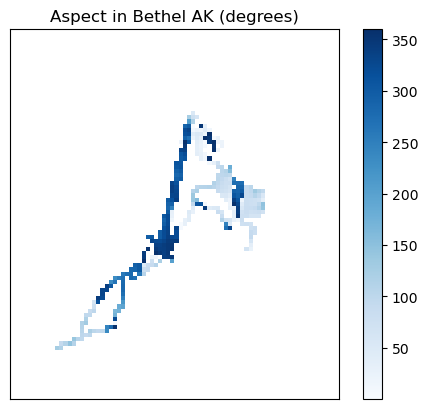

In [63]:
# Extract and plot aspect pixels within Nunapitchuk urban areas

aspect_urban = aspect_arr
for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v<21 or v>24:
            aspect_urban[index][i]=np.nan  
aspect_copy = np.where(aspect_urban == -9999, np.nan, aspect_urban)
plt.xticks([])
plt.yticks([])
plt.imshow(aspect_copy[180:270,70:150],cmap='Blues')
plt.title('Aspect in Nunapitchuk AK (degrees)')
plt.colorbar()
plt.show()

## Calculating Statistics Per Land Cover Type

In [64]:
# Remove land cover types that are not within the defined area of interest

unique_land = np.unique(lc_arr) # Define unique land cover types
list_keys = list(land_cover_labels.keys()) # List the keys in zipped file of land cover types
for x in list_keys:
    if x not in unique_land:
        land_cover_labels.pop(x)

In [65]:
# Calculate statistics for all layers by land cover type

standard_dev = dict()
unique = np.unique(lc_arr)
layers = [alt_copy,slope_copy,thaw_copy,thaw_rate_copy,cumulative_sub_copy]

layer_labels = ['Active Layer Thickness','Slope','Thaw Subsidence','Thaw Rate','Cumulative Subsidence']
total_stats={}
for x,z in zip(layers,layer_labels):
    land_cover_stats = {}
    for y in unique:
        if y!=0:
            selection = np.copy(x)
            value = lc_arr==y
            selection[value==False]=np.nan
            row_mean = np.nanmean(selection)
            row_std = np.nanstd(selection)
            land_cover_stats[y]=row_mean
            standard_dev[y]=row_std
    total_stats[z]=land_cover_stats

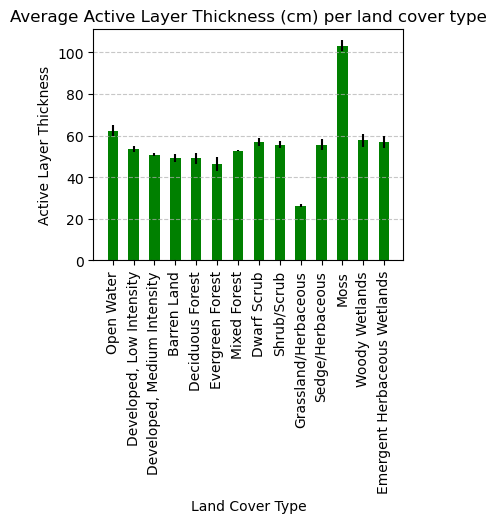

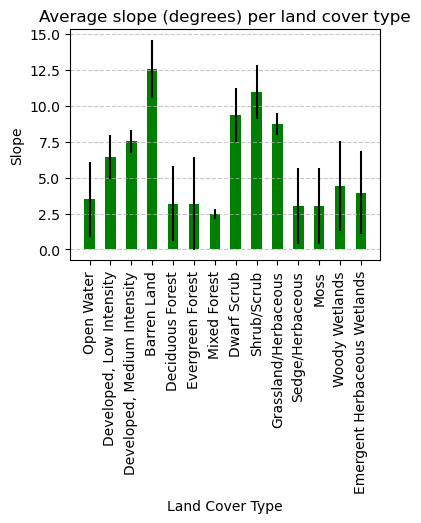

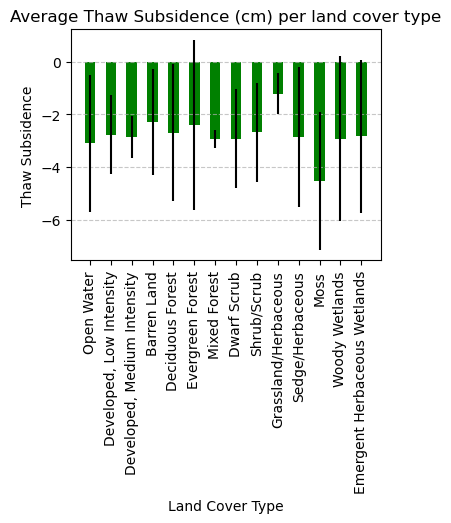

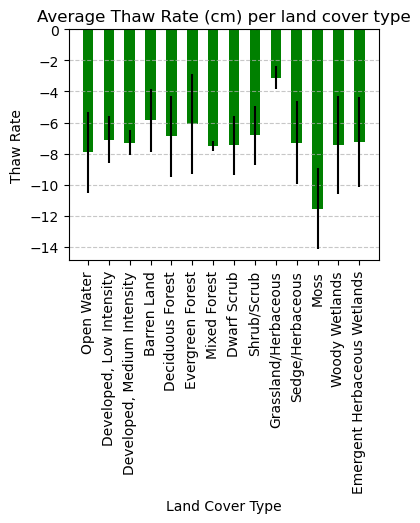

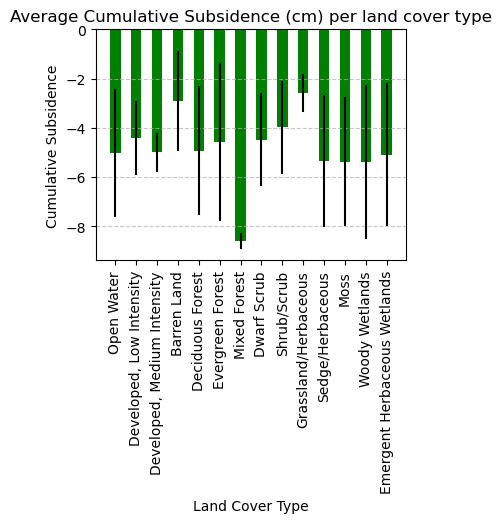

In [66]:
# Plot statistics for all layers by land cover type

for layer,stats in total_stats.items():
    x_values = []
    each_stat = total_stats[layer]
    for x in each_stat.keys():
        if x not in x_values:
            x_values.append(x)
    list_keys = list(land_cover_labels.keys())
    for x in list_keys:
        if x not in x_values:
            land_cover_labels.pop(x)
    labels = list(land_cover_labels.values())
    plt.figure(figsize=(4, 3))
    x_positions = np.arange(len(labels))  # Evenly spaced positions
    plt.bar(x_positions,list(each_stat.values()),yerr=standard_dev.values(),width=0.5,color='green')
    plt.xticks(x_positions,labels,rotation='vertical')
    if layer=='Slope':
        plt.title('Average slope (degrees) per land cover type')
    else: 
        plt.title(f"Average {layer} (cm) per land cover type")
    plt.xlabel('Land Cover Type')
    plt.ylabel(layer)
    plt.grid(axis='y', linestyle='--', alpha=0.7)




In [67]:
# Create table with average values for each layer

mean_value_df = pd.DataFrame(columns=['land_cover_type','land_cover_id','active_layer_thickness','slope',
                            'thaw_subsidence','thaw_rate','cumulative_subsidence'])
layer_labels = ['Active Layer Thickness','Thaw Subsidence','Thaw Rate','Cumulative Subsidence']

mean_value_df.land_cover_type = list(land_cover_labels.values())
mean_value_df.land_cover_id = x_values
mean_value_df.active_layer_thickness = total_stats['Active Layer Thickness'].values()
mean_value_df.slope = total_stats['Slope'].values()
mean_value_df.thaw_subsidence = total_stats['Thaw Subsidence'].values()
mean_value_df.thaw_rate = total_stats['Thaw Rate'].values()
mean_value_df.cumulative_subsidence = total_stats['Cumulative Subsidence'].values()
mean_value_df

,land_cover_type,land_cover_id,active_layer_thickness,slope,thaw_subsidence,thaw_rate,cumulative_subsidence
0,Open Water,11,62.308359,3.506807,-3.100750,-7.903448,-5.023643
1,"Developed, Low Intensity",22,53.337326,6.431619,-2.787216,-7.104287,-4.420676
2,"Developed, Medium Intensity",23,50.765099,7.521754,-2.863700,-7.299235,-5.004247
3,Barren Land,31,49.190818,12.566243,-2.301150,-5.865361,-2.907212
4,Deciduous Forest,41,49.031754,3.168491,-2.697552,-6.875743,-4.935021
5,Evergreen Forest,42,46.304027,3.193973,-2.397328,-6.110507,-4.590082
6,Mixed Forest,43,52.751444,2.455059,-2.951963,-7.524207,-8.605972
7,Dwarf Scrub,51,56.775304,9.376163,-2.927109,-7.460856,-4.480405
8,Shrub/Scrub,52,55.667936,10.963223,-2.682139,-6.836459,-3.989377
9,Grassland/Herbaceous,71,26.291151,8.722855,-1.217144,-3.102356,-2.582883


In [68]:
# Sort by active layer thickness ascending
# This table shows the land cover types with the largest average active layer thickness 

alt_df = mean_value_df.sort_values('active_layer_thickness',ascending=False)
alt_df_copy = pd.DataFrame(alt_df,columns=['land_cover_type','active_layer_thickness'])
alt_df_copy.head()


,land_cover_type,active_layer_thickness
11,Moss,103.120303
0,Open Water,62.308359
12,Woody Wetlands,57.716864
7,Dwarf Scrub,56.775304
13,Emergent Herbaceous Wetlands,56.752657


In [69]:
# Sort by thaw subsidence ascending
# This table shows the land cover types with the largest average thaw subsidence 

thaw_sub_df = mean_value_df.sort_values('thaw_subsidence',ascending=True)
thaw_sub_df_copy = pd.DataFrame(thaw_sub_df,columns=['land_cover_type','thaw_subsidence'])
thaw_sub_df_copy.head()


,land_cover_type,thaw_subsidence
11,Moss,-4.530568
0,Open Water,-3.100750
6,Mixed Forest,-2.951963
7,Dwarf Scrub,-2.927109
12,Woody Wetlands,-2.924451


In [70]:
# Sort by cumulative subsidence ascending
# This table shows the land cover types with the largest average cumulative 
# interannual subsidence (2018-2021)

cumulative_sub_df = mean_value_df.sort_values('cumulative_subsidence',ascending=True)
cumulative_sub_df_copy = pd.DataFrame(cumulative_sub_df,columns=['land_cover_type','cumulative_subsidence'])
cumulative_sub_df_copy.head()


,land_cover_type,cumulative_subsidence
6,Mixed Forest,-8.605972
12,Woody Wetlands,-5.395304
11,Moss,-5.375105
10,Sedge/Herbaceous,-5.355366
13,Emergent Herbaceous Wetlands,-5.099501


In [71]:
# Sort by max thaw rate ascending
# This table shows the land cover types with the largest average max thaw rate per year

thaw_rate_df = mean_value_df.sort_values('thaw_rate',ascending=True)
thaw_rate_df_copy = pd.DataFrame(thaw_rate_df,columns=['land_cover_type','thaw_rate'])
thaw_rate_df_copy.head()

,land_cover_type,thaw_rate
11,Moss,-11.547884
0,Open Water,-7.903448
6,Mixed Forest,-7.524207
7,Dwarf Scrub,-7.460856
12,Woody Wetlands,-7.454083


In [72]:
# Calculate average cumulative subsidence for slopes greater or less than certain threshold.

def slope_means(means_dict,layers,layer_labels,slope_percent): # Define function with four inputs
    for layer,label in zip(layers,layer_labels):  # Loop through layer names and labels
        slope_percentile = np.nanpercentile(slope_copy,slope_percent)  # Calculate slope value matching specified percentile
        slope_indices = np.where(slope_copy>slope_percentile)  # Find indices in slope raster where values are greater than specified percentile
        avg = np.nanmean(layer[slope_indices])  # Calculate the mean value for each layer within pixels in subsetted slope raster
        means_dict[label]=avg  # Add average to dictionary
    avg_values = [means_dict[label] for label in layer_labels]  # Construct a list of average values without keys
    return avg_values # Return the list

layers = [lc_arr,def_copy,alt_copy,thaw_copy,thaw_rate_copy,cumulative_sub_copy]
layer_labels = ['Land Cover','Deformation (cm)','Active Layer Thickness (cm)','Average Thaw Subsidence (cm)','Max Thaw Rate (cm/yr)','Cumulative Thaw Subsidence (cm)']
high_slope_means = {}
low_slope_means = {}

high_slope_values = slope_means(high_slope_means,layers,layer_labels,75)  # Calculate mean value for each layer above 75th percentile of slope values 
low_slope_values = slope_means(low_slope_means,layers,layer_labels,25)  # Calculate mean value for each layer below 25th percentile of slope values 
slope_means = pd.DataFrame({'Layer':layer_labels,'High Slope (>75th)': high_slope_values, 'Low Slope (<25th)': low_slope_values})
slope_means

,Layer,High Slope (>75th),Low Slope (<25th)
0,Land Cover,51.945575,57.444646
1,Deformation (cm),-0.015265,-0.014728
2,Active Layer Thickness (cm),54.959174,56.644246
3,Average Thaw Subsidence (cm),-2.809180,-2.906122
4,Max Thaw Rate (cm/yr),-7.160269,-7.407364
5,Cumulative Thaw Subsidence (cm),-4.052186,-4.895261
